In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [160]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
plt.style.use("seaborn")

In [2]:
df = pd.read_excel("project data/EAI6010Project.xlsx", sheet_name="RiskZoneData")

## Loading Geospatial Massachusetts data:

In [3]:
USA_geo = gpd.read_file("project data/mass_zcta/cb_2019_us_zcta510_500k.shp")

In [4]:
USA_geo["ZCTA5CE10"] = USA_geo["ZCTA5CE10"].map(lambda x: int(x))

In [5]:
zips = df["ZipCode"]
MA_geo = USA_geo[USA_geo["ZCTA5CE10"].isin(zips)]

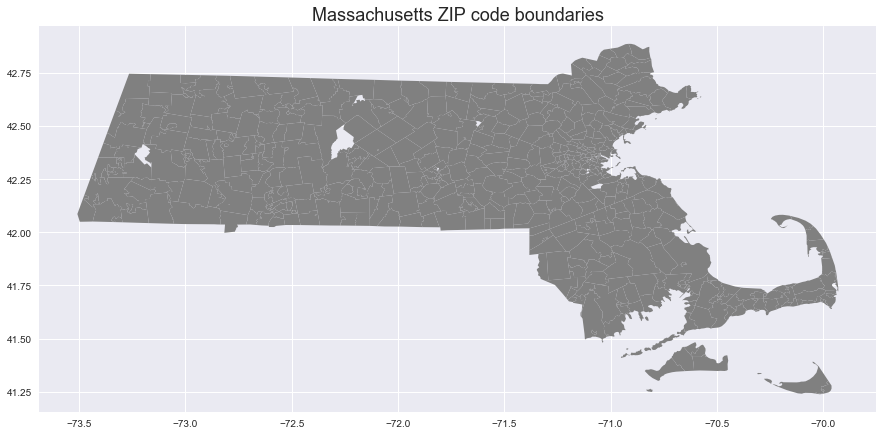

In [31]:
fig, ax = plt.subplots(1, figsize=(15, 15))
ma_plot = MA_geo.plot(ax=ax, color="gray")
plt.title("Massachusetts ZIP code boundaries", fontsize=18)
plt.show()

In [21]:
working_df = gpd.GeoDataFrame(pd.merge(left=df, right=MA_geo, left_on="ZipCode", right_on="ZCTA5CE10"))

## Blue Bikes data processing:

#### [Official open source data source](https://www.bluebikes.com/system-data)

In [10]:
bb_df = pd.read_csv("project data/202003-bluebikes-tripdata.csv")

In [11]:
bb_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,366,2020-03-01 00:01:09.0060,2020-03-01 00:07:15.2360,9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,446,700 Commonwealth Ave.,42.349609,-71.103915,5566,Customer,1969,0
1,367,2020-03-01 00:01:10.9500,2020-03-01 00:07:18.1970,9,Commonwealth Ave at Agganis Way,42.351692,-71.119035,446,700 Commonwealth Ave.,42.349609,-71.103915,4113,Customer,1969,0
2,120,2020-03-01 00:01:50.3890,2020-03-01 00:03:51.3510,372,Boylston St at Exeter St,42.349589,-71.079468,16,Back Bay T Stop - Dartmouth St at Stuart St,42.348074,-71.076570,4854,Subscriber,1960,1
3,646,2020-03-01 00:01:57.2720,2020-03-01 00:12:43.5950,328,Grove St at Community Path,42.396387,-71.120113,115,Porter Square Station,42.387995,-71.119084,3441,Subscriber,1994,1
4,424,2020-03-01 00:02:03.9240,2020-03-01 00:09:08.3250,104,Harvard University Radcliffe Quadrangle at She...,42.380287,-71.125107,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,5497,Subscriber,1962,2


In [18]:
from functools import partial
from shapely import geometry

def get_point(row, lat_name, long_name):
    return geometry.Point(row[long_name], row[lat_name])

get_start = partial(get_point, lat_name="start station latitude", long_name="start station longitude")
get_end = partial(get_point, lat_name="end station latitude", long_name="end station longitude")

bb_df["start_station_point"] = bb_df.apply(get_start, axis=1)
bb_df["end_station_point"] = bb_df.apply(get_end, axis=1)

In [ ]:
def calculate_trips_for_poly(bb_row, zip_poly):
    start_trip = bb_row.start_station_point.within(zip_poly)
    end_trip = bb_row.end_station_point.within(zip_poly)
    return any([start_trip, end_trip])
    
def find_number_of_trips(zone_row):
    trips = bb_df.apply(lambda x: calculate_trips_for_poly(x, zone_row.geometry), axis=1).value_counts()
    try:
        return trips[1]
    except KeyError:
        return 0

    
working_df["number_of_bb_trips"] = working_df.apply(find_number_of_trips, axis=1)

In [ ]:
working_df[["ZipCode", "number_of_bb_trips"]].to_csv("project data/bb_trips.csv")

## Public transport data processing:
#### [Bus stops MBTA public available dataset](https://docs.digital.mass.gov/dataset/massgis-data-mbta-bus-routes-and-stops)
#### [Rapid Transit stops MBTA public available dataset](https://maps-massgis.opendata.arcgis.com/datasets/a9e4d01cbfae407fbf5afe67c5382fde_0)

### Bus stops data:

In [24]:
mbta = gpd.read_file("project data/mbtabus/MBTABUSSTOPS_PT.shp")
mbta = mbta.to_crs(epsg=4326)

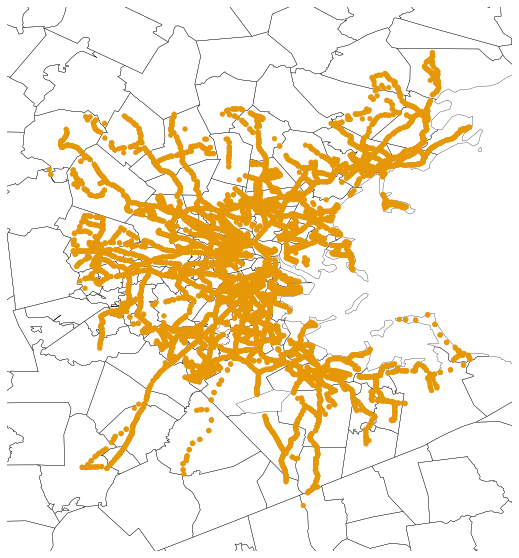

In [81]:
import geoplot


ax = geoplot.polyplot(MA_geo, figsize=(15, 10))
geoplot.pointplot(mbta, ax=ax, color="#e59706")
plt.show()

### Rapid transit stops data:

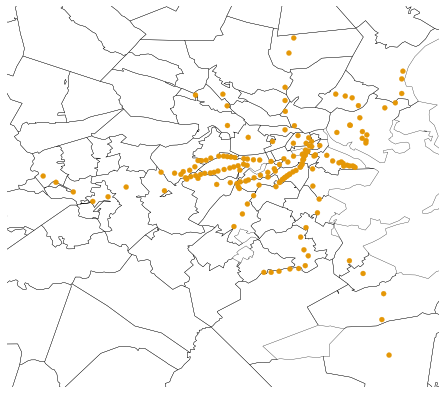

In [167]:
import geoplot


ax = geoplot.polyplot(MA_geo, figsize=(10, 7))
geoplot.pointplot(mbta_rapid_transit, ax=ax, color="#e59706")
plt.show()

In [82]:
mbta_rapid_transit = gpd.read_file("project data/mbta_rapid_transit/MBTA_NODE.shp")
mbta_rapid_transit = mbta_rapid_transit.to_crs(epsg=4326)

In [83]:
def stop_within_poly(bs_row, zip_poly):
    return bs_row.geometry.within(zip_poly)
    
    
def find_number_of_stops(zone_row, mbta_df):
    stops = mbta_df.apply(lambda x: stop_within_poly(x, zone_row.geometry), axis=1).value_counts()
    print(f"Counted for {zone_row.County} {zone_row.City} {zone_row.ZipCode}")
    try:
        n_stops =stops[1]
    except KeyError:
        n_stops = 0
        
    print(n_stops)
    return n_stops

working_df["number_of_bus_stops"] = working_df.apply(lambda x: find_number_of_stops(x, mbta), axis=1)
working_df["number_of_other_stops"] = working_df.apply(lambda x: find_number_of_stops(x, mbta_rapid_transit), axis=1)

Counted for Hampden Agawam 1001
0
Counted for Hampshire Amherst 1002
0
Counted for Hampshire Amherst 1003
0
Counted for Worcester Barre 1005
0
Counted for Hampshire Belchertown 1007
0
Counted for Hampden Blandford 1008
0
Counted for Hampden Bondsville 1009
0
Counted for Hampden Brimfield 1010
0
Counted for Hampden Chester 1011
0
Counted for Hampshire Chesterfield 1012
0
Counted for Hampden Chicopee 1013
0
Counted for Hampden Chicopee 1020
0
Counted for Hampden Chicopee 1022
0
Counted for Hampshire Cummington 1026
0
Counted for Hampshire Easthampton 1027
0
Counted for Hampden East Longmeadow 1028
0
Counted for Berkshire East Otis 1029
0
Counted for Hampden Feeding Hills 1030
0
Counted for Worcester Gilbertville 1031
0
Counted for Hampshire Goshen 1032
0
Counted for Hampshire Granby 1033
0
Counted for Hampden Granville 1034
0
Counted for Hampshire Hadley 1035
0
Counted for Hampden Hampden 1036
0
Counted for Worcester Hardwick 1037
0
Counted for Hampshire Hatfield 1038
0
Counted for Hamps

Counted for Worcester Worcester 1610
0
Counted for Worcester Cherry Valley 1611
0
Counted for Worcester Paxton 1612
0
Counted for Middlesex Framingham 1701
0
Counted for Middlesex Framingham 1702
0
Counted for Middlesex Village Of Nagog Woods 1718
0
Counted for Middlesex Boxborough 1719
0
Counted for Middlesex Acton 1720
0
Counted for Middlesex Ashland 1721
0
Counted for Middlesex Bedford 1730
59
Counted for Middlesex Hanscom Afb 1731
0
Counted for Worcester Bolton 1740
0
Counted for Middlesex Carlisle 1741
0
Counted for Middlesex Concord 1742
0
Counted for Worcester Fayville 1745
0
Counted for Middlesex Holliston 1746
0
Counted for Worcester Hopedale 1747
0
Counted for Middlesex Hopkinton 1748
0
Counted for Middlesex Hudson 1749
0
Counted for Middlesex Marlborough 1752
0
Counted for Middlesex Maynard 1754
0
Counted for Worcester Mendon 1756
0
Counted for Worcester Milford 1757
0
Counted for Middlesex Natick 1760
0
Counted for Middlesex Sherborn 1770
0
Counted for Worcester Southboroug

Counted for Middlesex Arlington 2476
82
Counted for Middlesex Belmont 2478
71
Counted for Norfolk Wellesley Hills 2481
0
Counted for Norfolk Wellesley 2482
0
Counted for Norfolk Needham 2492
9
Counted for Middlesex Weston 2493
0
Counted for Norfolk Needham Heights 2494
24
Counted for Barnstable Buzzards Bay 2532
0
Counted for Barnstable Cataumet 2534
0
Counted for Dukes Chilmark 2535
0
Counted for Barnstable East Falmouth 2536
0
Counted for Barnstable East Sandwich 2537
0
Counted for Plymouth East Wareham 2538
0
Counted for Dukes Edgartown 2539
0
Counted for Barnstable Falmouth 2540
0
Counted for Barnstable Buzzards Bay 2542
0
Counted for Barnstable Woods Hole 2543
0
Counted for Barnstable Monument Beach 2553
0
Counted for Nantucket Nantucket 2554
0
Counted for Barnstable North Falmouth 2556
0
Counted for Dukes Oak Bluffs 2557
0
Counted for Plymouth Onset 2558
0
Counted for Barnstable Pocasset 2559
0
Counted for Barnstable Sagamore 2561
0
Counted for Barnstable Sagamore Beach 2562
0
Co

Counted for Franklin Buckland 1338
0
Counted for Franklin Charlemont 1339
0
Counted for Franklin Colrain 1340
0
Counted for Franklin Conway 1341
0
Counted for Franklin Deerfield 1342
0
Counted for Berkshire Drury 1343
0
Counted for Franklin Erving 1344
0
Counted for Franklin Heath 1346
0
Counted for Franklin Lake Pleasant 1347
0
Counted for Franklin Millers Falls 1349
0
Counted for Franklin Monroe Bridge 1350
0
Counted for Franklin Montague 1351
0
Counted for Franklin Gill 1354
0
Counted for Franklin New Salem 1355
0
Counted for Franklin Northfield 1360
0
Counted for Franklin Orange 1364
0
Counted for Worcester Petersham 1366
0
Counted for Franklin Rowe 1367
0
Counted for Worcester Royalston 1368
0
Counted for Franklin Shelburne Falls 1370
0
Counted for Franklin South Deerfield 1373
0
Counted for Franklin Sunderland 1375
0
Counted for Franklin Turners Falls 1376
0
Counted for Franklin Warwick 1378
0
Counted for Franklin Wendell 1379
0
Counted for Worcester Fitchburg 1420
0
Counted for 

Counted for Suffolk Boston 2124
4
Counted for Suffolk Boston 2125
2
Counted for Suffolk Mattapan 2126
1
Counted for Suffolk Boston 2127
2
Counted for Suffolk Boston 2128
11
Counted for Suffolk Charlestown 2129
2
Counted for Suffolk Jamaica Plain 2130
6
Counted for Suffolk Roslindale 2131
0
Counted for Suffolk West Roxbury 2132
0
Counted for Suffolk Allston 2134
4
Counted for Suffolk Brighton 2135
7
Counted for Suffolk Hyde Park 2136
0
Counted for Middlesex Cambridge 2138
1
Counted for Middlesex Cambridge 2139
1
Counted for Middlesex Cambridge 2140
2
Counted for Middlesex Cambridge 2141
1
Counted for Middlesex Cambridge 2142
1
Counted for Middlesex Somerville 2143
0
Counted for Middlesex Somerville 2144
1
Counted for Middlesex Somerville 2145
1
Counted for Middlesex Malden 2148
2
Counted for Middlesex Everett 2149
0
Counted for Suffolk Chelsea 2150
4
Counted for Suffolk Revere 2151
3
Counted for Suffolk Winthrop 2152
0
Counted for Middlesex Medford 2155
1
Counted for Suffolk Boston 2163

In [ ]:
working_df[["number_of_other_stops", "ZipCode"]].to_csv("project data/other_stops.csv")
working_df[["ZipCode", "bus_stops"]].to_csv("project data/working_df_bs.csv")

## Park data processing:
#### [Massachusetts Park list](https://www.mass.gov/guides/alphabetical-list-of-massachusetts-state-parks)

In [85]:
import requests
from bs4 import BeautifulSoup

In [86]:
page = requests.get("https://www.mass.gov/guides/alphabetical-list-of-massachusetts-state-parks")
soup = BeautifulSoup(page.text, 'html.parser')

park_table_list = soup.find(class_="ma__stacked-row")
links = park_table_list.find_all("a")[:-4]

In [87]:
parks_links = []

for a_link in links:
    link = a_link.get("href")
    
    if "locations" in link:        
        parks_links.append({
            "park_name":a_link.contents[0],
            "url":f"https://www.mass.gov{a_link.get('href')}"
        })

In [88]:
import re


def parse_park_zip_code(url):
    page_park = requests.get(url)
    soup_park = BeautifulSoup(page_park.text, 'html.parser')
    contact_group_tag = soup_park.find(class_="ma__contact-group__address")
    address_content = contact_group_tag.contents[0]
    result = re.search(r'[0-9]{5}', address_content)
    return result.group(0)

In [90]:
from collections import Counter


zip_code_park_counter = Counter(map(lambda x: x["zip_code"], parks_links))

In [91]:
for park in parks_links:
    zip_code = parse_park_zip_code(park["url"])
    park["zip_code"] = zip_code
    
working_df["state_parks"] = working_df.apply(lambda x: zip_code_park_counter[x["GEOID10"]], axis=1)

In [ ]:
working_df[["ZipCode", "state_parks"]].to_csv("project data/state_parks.csv")

In [102]:
bb_trips = pd.read_csv("data_analysis/project_data/bb_trips.csv")
parks = pd.read_csv("data_analysis/project_data/state_parks.csv")
bus_stops = pd.read_csv("data_analysis/project_data/working_df_bs.csv")
rapid_stops = pd.read_csv("data_analysis/project_data/other_stops.csv")

dfs = [bb_trips, parks, bus_stops, rapid_stops]

In [117]:
from functools import reduce

features = reduce(lambda left, right: pd.merge(left, right), dfs)

In [245]:
wrkng = gpd.GeoDataFrame(pd.merge(working_df, features))

In [131]:
FEATURES = ["number_of_other_stops", "state_parks", "number_of_bb_trips", "bus_stops"]

In [128]:
# wrkng = wrkng[["GEOID10", "geometry", "number_of_other_stops", "state_parks", "number_of_bb_trips", "bus_stops"]]

In [246]:
wrkng["transmission_score"] = wrkng.apply(lambda row: row[FEATURES].sum(), axis=1)
wrkng["transmission_score"] = wrkng["transmission_score"].astype("float")
wrkng["risk_index"] = (wrkng["transmission_score"] / wrkng["transmission_score"].max()) * 100

In [249]:
wrkng["risk_index"] = wrkng["risk_index"].astype(int)

In [251]:
wrkng["zip_code"] = wrkng["ZipCode"].map(lambda x: f"0{x}")

In [253]:
wrkng["city"] = wrkng["City"]
wrkng["county"] = wrkng["County"]

In [288]:
wrkng.iloc[1,:]["geometry"].centroid.x

-72.46210483566628

In [291]:
wrkng["lat"] = wrkng.apply(lambda x: x["geometry"].centroid.x, axis=1)
wrkng["long"] = wrkng.apply(lambda x: x["geometry"].centroid.y, axis=1)

In [292]:
wrkng

,ZipCode,City,County,PublicTransport,OnlineDelivery,Lockdown,PopDensity,CommunityPlaces,BusinessesOpen,BikeUsage,...,Unnamed: 0,number_of_bb_trips,bus_stops,transmission_score,risk_index,zip_code,city,county,lat,long
0,1001,Agawam,Hampden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0.0,0,01001,Agawam,Hampden,-72.625892,42.062587
1,1002,Amherst,Hampshire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,1.0,0,01002,Amherst,Hampshire,-72.462105,42.374922
2,1003,Amherst,Hampshire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0,0,0.0,0,01003,Amherst,Hampshire,-72.524791,42.391919
3,1005,Barre,Worcester,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,0,0,0.0,0,01005,Barre,Worcester,-72.106150,42.420174
4,1007,Belchertown,Hampshire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,0,0,1.0,0,01007,Belchertown,Hampshire,-72.400360,42.278750
5,1008,Blandford,Hampden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,0,0,0.0,0,01008,Blandford,Hampden,-72.952030,42.184278
6,1009,Bondsville,Hampden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,0,0,0.0,0,01009,Bondsville,Hampden,-72.339714,42.209715
7,1010,Brimfield,Hampden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7,0,0,1.0,0,01010,Brimfield,Hampden,-72.206243,42.128635
8,1011,Chester,Hampden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8,0,0,0.0,0,01011,Chester,Hampden,-72.959680,42.296519
9,1012,Chesterfield,Hampshire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,0,0,0.0,0,01012,Chesterfield,Hampshire,-72.846337,42.386988


In [293]:
risk_index = pd.DataFrame(wrkng[["city", "county", "zip_code", "risk_index", "lat", "long"]])

In [294]:
with open("data_analysis/project_data/risk_index.json", "w+") as f:
    f.write(risk_index.to_json())

In [158]:
with open("data_analysis/project_data/risk_index.geojson", "w+") as f:
    f.write(wrkng.to_json())

In [271]:
risk_index.shape

(537, 4)

In [168]:
r = requests.get("https://www.mass.gov/doc/covid-19-raw-data-may-10-2020/download")

In [172]:
import zipfile

In [206]:
from io import BytesIO
a = zipfile.ZipFile(BytesIO(r.content))

In [190]:
a.extractall("data_analysis/project_data/MA_COVID")

In [208]:
with a.open("County.csv") as f:
    b = pd.read_csv(f)

In [191]:
counties_cases_df = pd.read_csv("data_analysis/project_data/MA_COVID/County.csv")

In [197]:
counties_cases_df[counties_cases_df["Date"] == "5/10/2020"]

,Date,County,Count,Deaths
1085,5/10/2020,Barnstable,1068.0,68.0
1086,5/10/2020,Berkshire,475.0,37.0
1087,5/10/2020,Bristol,4931.0,266.0
1088,5/10/2020,Dukes,23.0,NaN
1089,5/10/2020,Essex,11353.0,644.0
1090,5/10/2020,Franklin,294.0,42.0
1091,5/10/2020,Hampden,4714.0,449.0
1092,5/10/2020,Hampshire,676.0,55.0
1093,5/10/2020,Middlesex,17589.0,1207.0
1094,5/10/2020,Nantucket,12.0,NaN


In [234]:
counties_cases_df["Date"] = pd.to_datetime(counties_cases_df["Date"], infer_datetime_format=True).dt.date

In [221]:
a = datetime.date.today()

a

datetime.date(2020, 5, 11)

In [222]:
a.strftime("%m/%d/%Y")

'05/11/2020'

In [241]:
pd.set_option('display.max_rows', 1200)

In [309]:
X = pd.read_excel("data_analysis/project_data/data.xlsx")

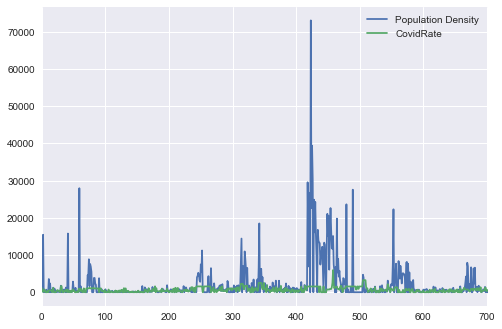

In [314]:
import seaborn as sns


X[["Population Density", "CovidRate"]].plot()
plt.show()

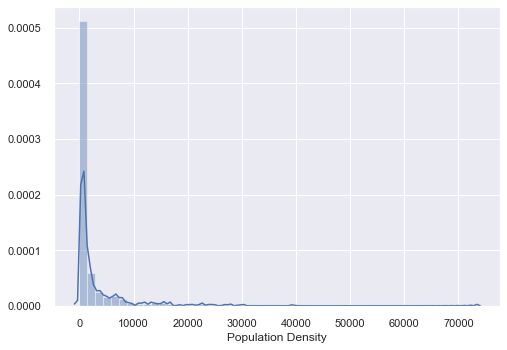

In [320]:
sns.set(); np.random.seed(0)
x = np.random.randn(100)
ax = sns.distplot(X["Population Density"])


In [318]:
x

array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ,
        0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323,
        0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574,
       -2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462,
       -1.45436567,  0.04575852, -0.18718385,  1.53277921,  1.46935877,
        0.15494743,  0.37816252, -0.88778575, -1.98079647, -0.34791215,
        0.15634897,  1.23029068,  1.20237985, -0.38732682, -0.30230275,
       -1.04855297, -1.42001794, -1.70627019,  1.9507754 , -0.50965218,
       -0.4380743 , -1.25279536,  0.77749036, -1.61389785, -0.21274028,
       -0.89546656,  0.3869025 , -0.51080514, -1.18063218, -0.02818223,
        0.42833187,  0.06651722,  0.3024719 , -0.63432209, -0.36274117,
       -0.67246045, -0.35955316, -0.81314628, -1.7262826 ,  0.17742614,
       -0.40178094, -1.63019835,  0.46278226, -0.90729836,  0.05

In [332]:
A = X.drop_duplicates("City")

In [342]:
A = X.groupby(["City"]).sum()

In [346]:
A[A.index == "Boston"]

,ZipCode,PublicTransport_BusStops,PublicTransport_OtherStops,CommunityPlaces,BikeUsage,HealthIndex,Population,Population Density,"Transportation, Warehousing, Utilities Workers Percentage",Retail Trade Workers Percentage,Population in Poverty Percentage,10 or More Units House Percentage,StateParks,CovidCount,CovidRate
City,,,,,,,,,,,,,,,
Boston,100257,1102.0,92.0,97,88147.0,506,405070,457557.0,0.497,1.628,4.673,10.72,10.0,493534,71014.8


In [429]:
y = A["CovidCount"]

In [351]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

linear_regression = LinearRegression()
random_forests = RandomForestRegressor()
ada = AdaBoostRegressor()

In [430]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(A, y, train_size=0.85)

In [431]:
FEATURES = list(filter(lambda x: x != "CovidRate" and x != "CovidCount", X_train.columns))

In [432]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

In [434]:
from sklearn.model_selection import cross_validate


def evaluate_learners(classifiers, X, y):
    cross_validations = [cross_validate(model, X, y, return_train_score=True) for model in classifiers]

    return (
        list(map(lambda x: x["train_score"], cross_validations)),
        list(map(lambda x: x["test_score"], cross_validations))
    )

In [439]:
linear_regression = LinearRegression()
random_forests = RandomForestRegressor()
ada = AdaBoostRegressor()

linear_regression.fit(X_train, y_train)
random_forests.fit(X_train, y_train)
ada.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [443]:
ada.score(X_test, y_test)

0.8524383181392459

In [448]:
from sklearn.metrics import r2_score

preds = ada.predict(X_test)
r2_score(y_test, preds)

0.8524383181392459

In [449]:
ada.score(X_test, y_test)

0.8524383181392459

In [445]:
X.describe()

,ZipCode,PublicTransport_BusStops,PublicTransport_OtherStops,CommunityPlaces,BikeUsage,HealthIndex,Population,Population Density,"Transportation, Warehousing, Utilities Workers Percentage",Retail Trade Workers Percentage,Population in Poverty Percentage,10 or More Units House Percentage,StateParks,CovidCount,CovidRate
count,703.000000,537.000000,537.000000,703.000000,537.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,537.000000,703.000000,703.000000
mean,1903.635846,14.532588,0.305400,3.503556,346.633147,7.836415,9469.860597,2154.591323,0.027165,0.080418,0.075058,0.077458,0.284916,1029.174964,658.292859
std,568.324797,39.118498,1.445473,3.647139,1944.492572,4.129007,12032.776572,5360.984376,0.031469,0.060838,0.094571,0.140604,0.597582,2650.702541,642.931609
min,1001.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1461.000000,0.000000,0.000000,1.000000,0.000000,5.000000,80.500000,18.200000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,158.380000
50%,1915.000000,0.000000,0.000000,2.000000,0.000000,9.000000,4306.000000,360.200000,0.025000,0.091000,0.049000,0.022000,0.000000,73.000000,505.130000
75%,2345.500000,0.000000,0.000000,5.000000,0.000000,11.000000,14739.500000,1491.300000,0.042500,0.122000,0.098000,0.101500,0.000000,443.000000,1020.000000
max,5544.000000,330.000000,15.000000,23.000000,31013.000000,14.000000,60293.000000,73083.600000,0.500000,0.477000,1.000000,1.000000,5.000000,10729.000000,5957.900000
